# ch05. Droupout_code
## artifical code

ps.
 
pip install d2l

pip install matplotlib==3.0.0

In [1]:
import torch
import torch.nn as nn
from d2l import torch as d2l
import matplotlib.pyplot as plt

In [2]:
def dropout_layer(X, dropout): 
    assert 0 <= dropout <= 1 # 在本情况中，所有元素都被丢弃 
    if dropout == 1:
        return torch.zeros_like(X) # 在本情况中，所有元素都被保留
    if dropout == 0:
        return X
    mask = (torch.rand(X.shape) > dropout).float() 
    return mask * X / (1.0 - dropout)

In [3]:
X= torch.arange(16, dtype = torch.float32).reshape((2, 8))
print(dropout_layer(X, 0.))
print(dropout_layer(X, 0.5))
print(dropout_layer(X, 1.))

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  0.,  4.,  6.,  0.,  0.,  0.,  0.],
        [ 0., 18.,  0., 22.,  0.,  0., 28., 30.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


In [4]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

In [5]:
dropout1, dropout2 = 0.2, 0.5
class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2,
                is_training = True): 
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()
    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs)))) # 只有在训练模型时才使用dropout
        if self.training == True:
            # 在第一个全连接层之后添加一个dropout层
            H1 = dropout_layer(H1, dropout1) 
        H2 = self.relu(self.lin2(H1))
        if self.training == True:
            # 在第二个全连接层之后添加一个dropout层
            H2 = dropout_layer(H2, dropout2) 
        out = self.lin3(H2)
        return out

In [6]:
net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)

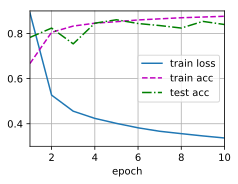

In [7]:
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss(reduction='none')
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

## torch code

In [8]:
import torch
import torch.nn as nn
from d2l import torch as d2l
import matplotlib.pyplot as plt

1. 载入数据集

In [9]:
num_epochs, lr, batch_size = 10, 0.5, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


2. 定义网络
增加两个hidden layer且增加dropout

In [10]:
dropout1, dropout2 = 0.2, 0.5

net = nn.Sequential(
    # 铺平
    nn.Flatten(),
    nn.Linear(784, 256),
    nn.ReLU(),
    # hidden layer 1 增加dropout
    nn.Dropout(dropout1),
    nn.Linear(256, 256),
    nn.ReLU(),
    # hidden layer 2 增加dropout
    nn.Dropout(dropout2),
    nn.Linear(256, 10)
)

3. 初始化参数

In [11]:
def init_weights(m):
  if type(m) == nn.Linear:
    nn.init.normal_(m.weight, std=0.01)
    nn.init.normal_(m.bias, std=0.01)
net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.5, inplace=False)
  (7): Linear(in_features=256, out_features=10, bias=True)
)

4. 定义损失函数

In [12]:
loss = nn.CrossEntropyLoss()

5. 定义优化器

In [13]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.5)

6.Training and Prediction

In [14]:
def acc(X,y,net):
  p_predict = net(X)
  y_predict = torch.argmax(p_predict,axis=1)
  output = y_predict - y
  right_pre = len(output[output==0])
  right_accu = right_pre/len(output)
  return right_accu

- Note: 当进行Dropout时，hidden layer每层进行dropout时都会随机drop掉单元，所以在测试数据时这个过程也会发生，在训练时设置net.train()模式，在测试时设置net.eval()模式固定住训练完的net。

In [15]:
epochs = 20
train_accu_history = []
test_accu_history = []
train_loss = []


for epoch in range(epochs):

  net.train()

  for X,y in train_iter:
    l = loss(net(X), y)
    optimizer.zero_grad()
    l.backward()
    optimizer.step()

  l = loss(net(X), y)
  train_loss.append(l.detach())

  net.eval()
  train_batch = 0
  train_accu = 0
  
  test_batch = 0
  test_accu = 0
  
  for X_train,y_train in train_iter:
    train_accu += acc(X_train, y_train, net)
    train_batch += 1
    train_avg_acc = train_accu/train_batch
  train_accu_history.append(train_avg_acc)

  for X_test,y_test in test_iter:
    test_accu += acc(X_test, y_test, net)
    test_batch += 1
    avg_acc = test_accu/test_batch
  test_accu_history.append(avg_acc)


  print(f'epoch {epoch + 1}, loss {l:f}, train_accu {train_avg_acc:f}, test_accu {avg_acc:f}')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1, loss 0.649188, train_accu 0.729992, test_accu 0.724316
epoch 2, loss 0.457127, train_accu 0.768661, test_accu 0.757129
epoch 3, loss 0.327704, train_accu 0.804239, test_accu 0.791895
epoch 4, loss 0.673608, train_accu 0.778779, test_accu 0.764160
epoch 5, loss 0.267582, train_accu 0.856206, test_accu 0.845117
epoch 6, loss 0.316294, train_accu 0.855890, test_accu 0.844922
epoch 7, loss 0.258618, train_accu 0.864306, test_accu 0.848828
epoch 8, loss 0.273264, train_accu 0.868008, test_accu 0.846973
epoch 9, loss 0.112966, train_accu 0.882064, test_accu 0.869238
epoch 10, loss 0.271820, train_accu 0.877388, test_accu 0.859766
epoch 11, loss 0.291703, train_accu 0.887046, test_accu 0.868555
epoch 12, loss 0.250491, train_accu 0.881632, test_accu 0.862012
epoch 13, loss 0.286625, train_accu 0.867858, test_accu 0.852246
epoch 14, loss 0.304318, train_accu 0.833067, test_accu 0.818359
epoch 15, loss 0.168675, train_accu 0.890625, test_accu 0.867676
epoch 16, loss 0.218592, train_acc

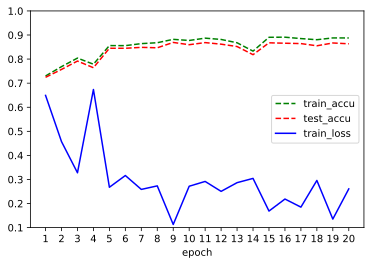

In [16]:
x_label_value = [str(i) for i in range(1,epochs+1)]
plt.plot(x_label_value, train_accu_history, label='train_accu', color='g', linestyle='dashed')
plt.plot(x_label_value, test_accu_history, label='test_accu', color='r', linestyle='dashed')
plt.plot(x_label_value, train_loss, label='train_loss', color='b')
plt.xlabel('epoch')
plt.ylim(0.1,1)
plt.legend()
plt.show()